In [2]:
%matplotlib inline
import glob
import h5py
import numpy as np
from brainspace.gradient import GradientMaps
from brainspace.gradient import alignment
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
import helpers

HCPFilenamesList = glob.glob('../IndSubHCP/*.mat')
HCPFilenamesList.sort()
SurfaceMask=np.loadtxt('surfBilateralMask.txt')

numFiles=len(HCPFilenamesList)
numV_l=np.count_nonzero(SurfaceMask[:5000])
numV_l=np.count_nonzero(SurfaceMask[5000:])

num_bins=20
dist_mat_file = "SurfL10kConte.txt"
dist_mat_file_r = "SurfR10kConte.txt"
dist_file=np.loadtxt(dist_mat_file)
dist_file_r=np.loadtxt(dist_mat_file_r)
dist_file_masked=dist_file[np.ix_(SurfaceMask[:5000]==1,SurfaceMask[:5000]==1)]
dist_file_masked_r=dist_file_r[np.ix_(SurfaceMask[5000:]==1,SurfaceMask[5000:]==1)]


FC_l=np.zeros([dist_file_masked.shape[0],dist_file_masked.shape[0]])
FC_r=np.zeros([dist_file_masked_r.shape[0],dist_file_masked_r.shape[0]])


for i,dataName in enumerate(HCPFilenamesList):


    print(dataName)
    f = h5py.File(dataName)
    arrays = {}
    for k, v in f.items():
        arrays[k] = np.array(v)

    IndData1=arrays['rfMRI_REST1_LR']
    
    tempData=IndData1[:5000,:]
    tempDataReduced=tempData[SurfaceMask[:5000]==1,:]
    tempFC=np.corrcoef(tempDataReduced)
    tempFC=np.arctanh(tempFC)
    np.fill_diagonal(tempFC,3)
    FC_l=FC_l+tempFC
    
    tempData=IndData1[5000:,:]
    tempDataReduced=tempData[SurfaceMask[5000:]==1,:]
    tempFC=np.corrcoef(tempDataReduced)
    tempFC=np.arctanh(tempFC)
    np.fill_diagonal(tempFC,3)
    FC_r=FC_r+tempFC
    
FC_l=FC_l/(numFiles+1)
FC_l=np.tanh(FC_l)

FC_r=FC_r/(numFiles+1)
FC_r=np.tanh(FC_r)

../IndSubHCP/HCP_100408_downsample_hemiTimeseries.mat


/var/folders/sf/n3ybtcn11h30c98lywmccxr80000gn/T/ipykernel_12306/1743908638.py:47: RuntimeWarning: divide by zero encountered in arctanh
  tempFC=np.arctanh(tempFC)
/var/folders/sf/n3ybtcn11h30c98lywmccxr80000gn/T/ipykernel_12306/1743908638.py:54: RuntimeWarning: divide by zero encountered in arctanh
  tempFC=np.arctanh(tempFC)


../IndSubHCP/HCP_100610_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_101006_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_102513_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_102816_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_103414_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_103515_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_103818_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_104416_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_105620_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_106521_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_107018_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_108222_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_108525_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_109123_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_109830_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_110007_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_110411_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_110613_downsample_hemiTimeseries.mat
../IndSubHCP/HCP_111009_down

In [3]:
#fit a theoretical variogram
from scipy import special
from scipy.optimize import curve_fit
import math


hVw_l,evVw_l=helpers.emp_variogram_vwise_conn(FC_l,dist_file_masked,num_bins,[0,150]) #vary last number for maximum range 
hVw_r,evVw_r=helpers.emp_variogram_vwise_conn(FC_r,dist_file_masked_r,num_bins,[0,150]) #vary last number for maximum range 


def hole(h, r, c0,nugget):
    a = r/3
    theoVar=nugget + c0*(1-np.sin(h/a)/(h/a))

    return theoVar
              
def gaussian(h, r, c0, nugget):
    a = r / 2
    return nugget + c0 * (1. - np.exp(- (h ** 2 / a ** 2)))

def exponential(h,r,c0,nugget):
    theoVar=nugget+c0*(1-np.exp(-h/(r/3)))
    return theoVar

models=[hole, exponential, gaussian]





clipStart=1
clipEnd=18

ModelPred_evVw_l=np.zeros([evVw_l.shape[0],3,num_bins-3])
ModelSSE_evVw_l=np.zeros([evVw_l.shape[0],3])
ModelCof_evVw_l=np.zeros([evVw_l.shape[0],3,3])


for j in range(evVw_l.shape[0]):
    y=evVw_l[j,clipStart:clipEnd]
    x=hVw_l[j,clipStart:clipEnd]
    bounds = (0.00001, [np.nanmax(x),np.nanmax(y),np.nanmax(y)/10])

    cof = None
    cov = None

    for ind,model in enumerate(models):

        cof, cov = curve_fit(model,x, y, method='trf',p0=bounds[1],bounds=bounds,maxfev=5000)
        v_pred=model(x,*cof)
        ModelPred_evVw_l[j,ind,:]=v_pred
        ModelSSE_evVw_l[j,ind]=np.sum((v_pred-y)**2)
        ModelCof_evVw_l[j,ind,:]=cof


        
ModelPred_evVw_r=np.zeros([evVw_r.shape[0],3,num_bins-3])
ModelSSE_evVw_r=np.zeros([evVw_r.shape[0],3])
ModelCof_evVw_r=np.zeros([evVw_r.shape[0],3,3])


for j in range(evVw_r.shape[0]):
    y=evVw_r[j,clipStart:clipEnd]

    x=hVw_r[j,clipStart:clipEnd]

    bounds = (0.00001, [np.nanmax(x),np.nanmax(y),np.nanmax(y)/10])

    cof = None
    cov = None

    for ind,model in enumerate(models):

        cof, cov = curve_fit(model,x, y, method='trf',p0=bounds[1],bounds=bounds,maxfev=5000)
        v_pred=model(x,*cof)
        ModelPred_evVw_r[j,ind,:]=v_pred
        ModelSSE_evVw_r[j,ind]=np.sum((v_pred-y)**2)
        ModelCof_evVw_r[j,ind,:]=cof


            
    


In [5]:

tempData=np.zeros([5000,3])
tempData[SurfaceMask[:5000]==1,:]=ModelCof_evVw_l[:,:,0]
np.savetxt('./imagesAvG/FC_Range_left.txt',tempData)
tempData=np.zeros([5000,3])
tempData[SurfaceMask[5000:]==1,:]=ModelCof_evVw_r[:,:,0]
np.savetxt('./imagesAvG/FC_Range_right.txt',tempData)


tempData=np.zeros([5000,3])
tempData[SurfaceMask[:5000]==1,:]=ModelCof_evVw_l[:,:,1]
np.savetxt('./imagesAvG/FC_Sill_left.txt',tempData)
tempData=np.zeros([5000,3])
tempData[SurfaceMask[5000:]==1,:]=ModelCof_evVw_r[:,:,1]
np.savetxt('./imagesAvG/FC_Sill_right.txt',tempData)


In [6]:
from brainspace.gradient import GradientMaps
from brainspace.gradient import alignment



numComp=3

#gmr = GradientMaps(n_components=numComp, approach='dm', kernel='normalized_angle')
gmr = GradientMaps(n_components=numComp,approach='le')

gmr.fit(FC_r)

tempData=np.zeros([5000,3])
tempData[SurfaceMask[5000:]==1,:]=gmr.gradients_
np.savetxt('./imagesAvG/GradientFC_right.txt',tempData)

#gml = GradientMaps(n_components=numComp, approach='dm', kernel='normalized_angle')
gml = GradientMaps(n_components=numComp,approach='le')
gml.fit(FC_l)
tempData=np.zeros([5000,3])
tempData[SurfaceMask[:5000]==1,:]=gml.gradients_
np.savetxt('./imagesAvG/GradientFC_left.txt',tempData)







/opt/homebrew/lib/python3.9/site-packages/brainspace/gradient/embedding.py:206: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


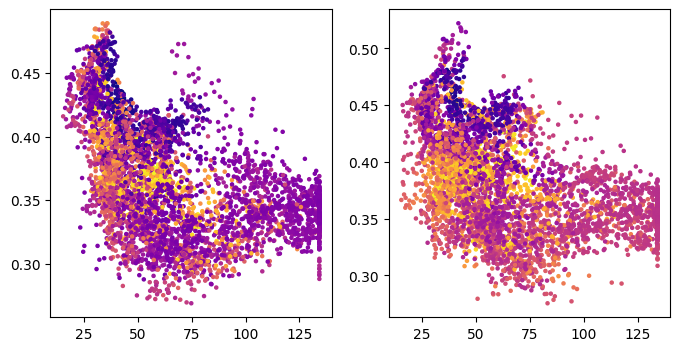

In [7]:
#from scipy import stats
#stats.spearmanr(ModelCof_evVw_l[:,1,1],gml.gradients_[:,0])

import matplotlib

matplotlib.rc_file_defaults()
#print(np.corrcoef(ModelCof_IndWBev_l[:,1,0],ModelCof_IndWBev_l_2[:,1,0]))

fig, axs = plt.subplots(1,2,figsize=(8,4))
fig.patch.set_alpha(0)
#print(stats.spearmanr(ModelCof_IndWBev_l[:,1,0],ModelCof_IndWBev_l_2[:,1,0]))

axs[0].scatter(ModelCof_evVw_l[:,1,0],ModelCof_evVw_l[:,1,1],c=gml.gradients_[:,2],cmap='plasma',s=5)
axs[0].grid(False)



im=axs[1].scatter(ModelCof_evVw_r[:,1,0],ModelCof_evVw_r[:,1,1],c=gmr.gradients_[:,2]*-1,cmap='plasma',s=5)
axs[1].grid(False)

#fig.colorbar(im,ax=axs[1])
plt.savefig('./imagesAvG/RangeSill_Gradient_3.png')



#plt.scatter(ModelCof_evVw_l[:,1,0],ModelCof_evVw_l[:,1,1],c=gml.gradients_[:,0])

/opt/homebrew/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 800x800 with 0 Axes>

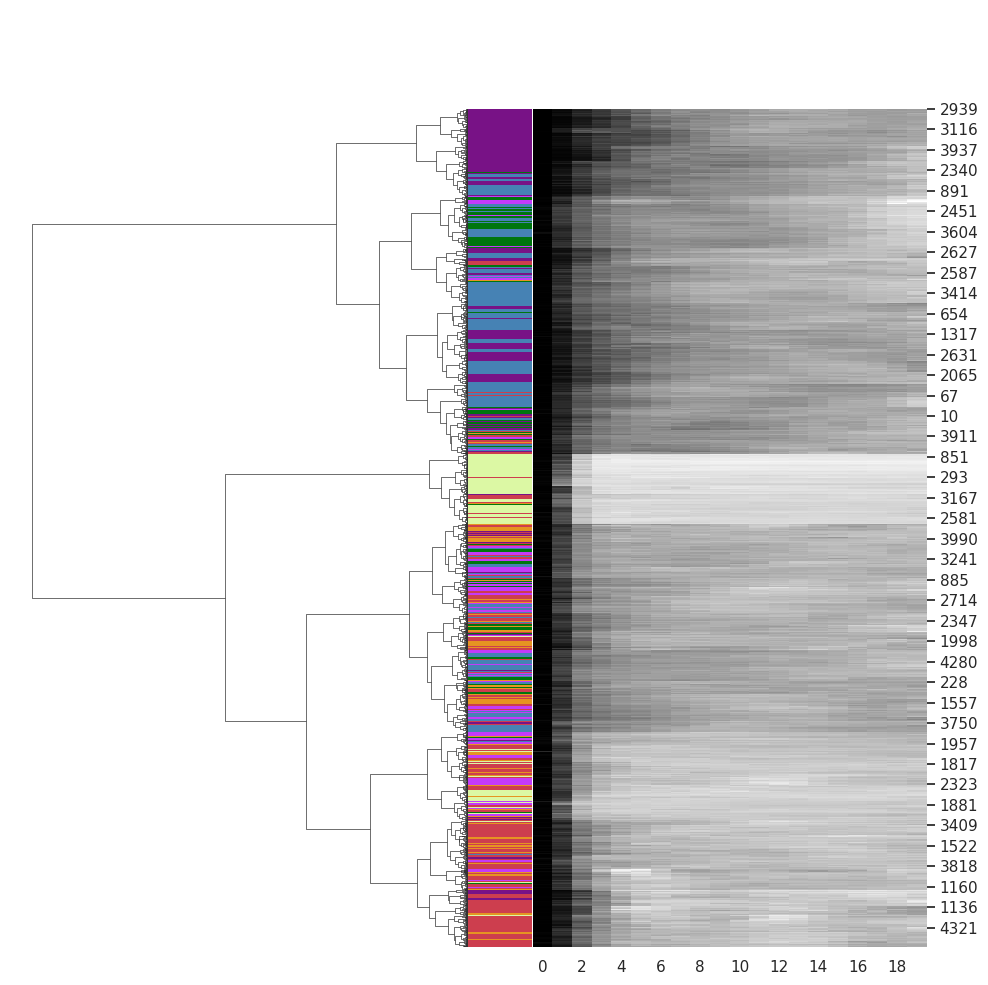

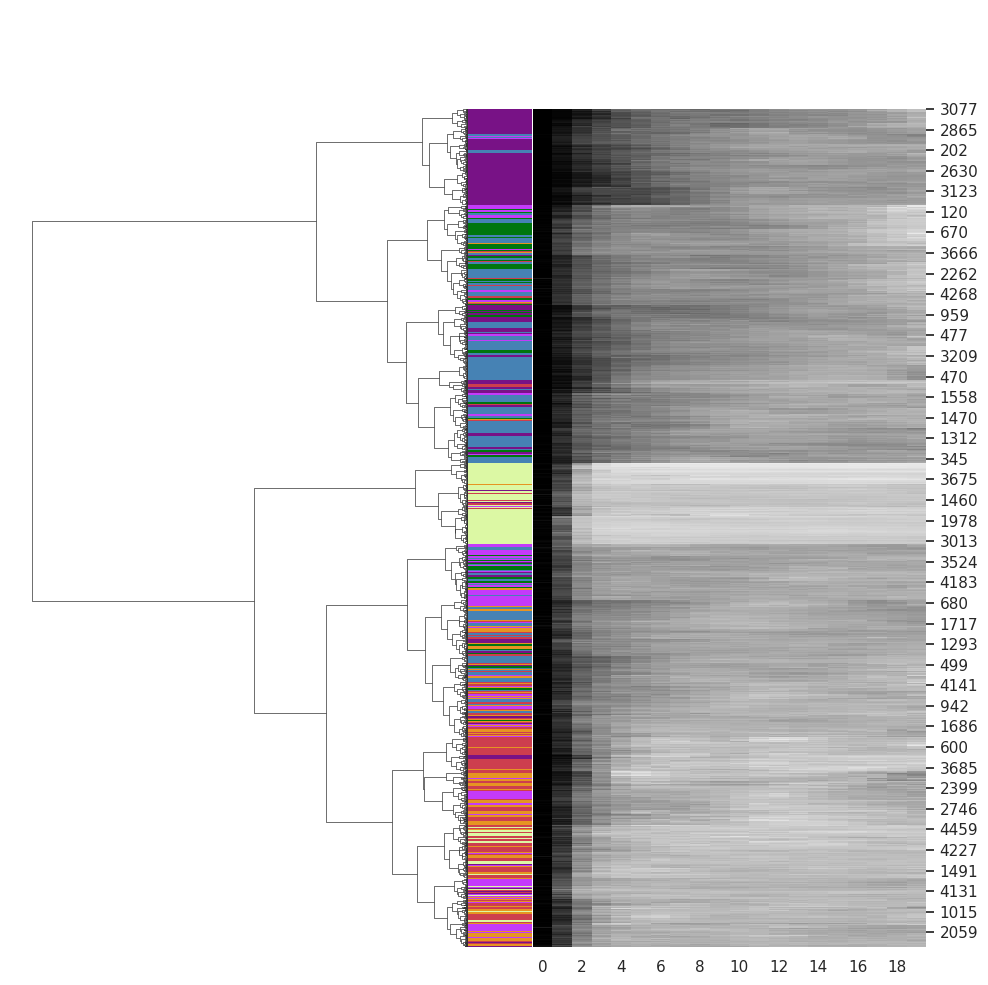

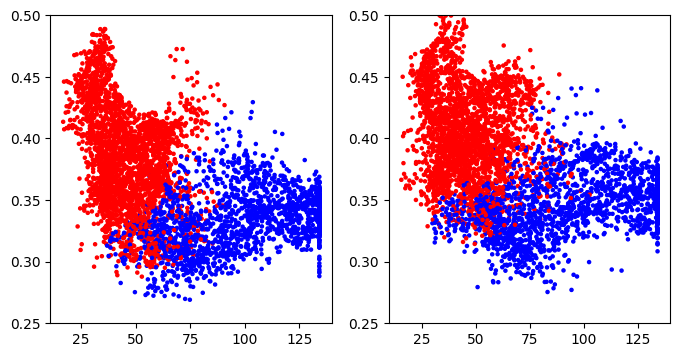

In [8]:

import matplotlib 


import seaborn as sns; sns.set_theme(color_codes=True)

import matplotlib.cm as cm
from matplotlib import colors
import pandas as pd
import seaborn as sns

fig = plt.figure(figsize=(8,8))

YeoNames=['NONE',
'7Networks_3',
'7Networks_6',
'7Networks_7',
'7Networks_1',
'7Networks_5',
'7Networks_2',
'7Networks_4'];

YeoColors=np.loadtxt('Yeo2011_7Networks_ColorLUT.txt','str')
angle=0
RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNL=RSN[:,:5000]
RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7,YeoIndices=np.unique(RSNL_masked,return_inverse=True)
YeoColorList=np.zeros([RSNL_masked.shape[0],3])

for i in range(RSNL_masked.shape[0]):
    tempBool=YeoColors[:,1]==YeoNames[YeoIndices[i]]
    temp_col=np.asarray([YeoColors[tempBool,2],YeoColors[tempBool,3],YeoColors[tempBool,4]], dtype=int).ravel()
    YeoColorList[i]=temp_col

X = evVw_l
g = sns.clustermap(X[YeoIndices>0,:], row_colors=YeoColorList[YeoIndices>0]/255,metric="euclidean",method="ward",dendrogram_ratio=(.5, .1),colors_ratio=(0.07,0.03),col_cluster=False,cbar_pos=None,cmap="gray")
g.savefig('/Users/robleech/Dropbox/BrainSmash/imagesAvG/Dendogram_l.png')

from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(X[YeoIndices>0,:], metric="euclidean",method="ward")

from scipy.cluster.hierarchy import fcluster
fl_l = fcluster(Z,2,criterion='maxclust')

RSNR=RSN[:,5000:]
RSNR_masked=RSNR[RSNAtlas,SurfaceMask[5000:]==1]
yeo7,YeoIndices=np.unique(RSNR_masked,return_inverse=True)
YeoColorList=np.zeros([RSNR_masked.shape[0],3])


for i in range(RSNR_masked.shape[0]):
    tempBool=YeoColors[:,1]==YeoNames[YeoIndices[i]]
    temp_col=np.asarray([YeoColors[tempBool,2],YeoColors[tempBool,3],YeoColors[tempBool,4]], dtype=int).ravel()
    
    YeoColorList[i]=temp_col
    #YeoColorInt[i]=i

X = evVw_r

g = sns.clustermap(X[YeoIndices>0,:], row_colors=YeoColorList[YeoIndices>0]/255,metric="euclidean",method="ward",dendrogram_ratio=(.5, .1),colors_ratio=(0.07,0.03),col_cluster=False,cbar_pos=None,cmap="gray")

g.savefig('/Users/robleech/Dropbox/BrainSmash/imagesAvG/Dendogram_r.png')

Z = linkage(X[YeoIndices>0,:], metric="euclidean",method="ward")
fl_r = fcluster(Z,2,criterion='maxclust')


RSNL=RSN[:,:5000]
RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7,YeoIndices=np.unique(RSNL_masked,return_inverse=True)
YeoColorList=np.zeros([RSNL_masked.shape[0],3])

matplotlib.rc_file_defaults()
cmap='bwr'
fig, axs = plt.subplots(1,2,figsize=(8,4))
fig.patch.set_alpha(0)

axs[0].scatter(ModelCof_evVw_l[YeoIndices>0,1,0],ModelCof_evVw_l[YeoIndices>0,1,1],c=fl_l,cmap=cmap,s=5)
axs[0].grid(False)
axs[0].set_ylim(bottom=0.25, top=0.5)

RSNR=RSN[:,5000:]
RSNR_masked=RSNR[RSNAtlas,SurfaceMask[5000:]==1]
yeo7,YeoIndices=np.unique(RSNR_masked,return_inverse=True)
YeoColorList=np.zeros([RSNR_masked.shape[0],3])

cmap='bwr'

axs[1].scatter(ModelCof_evVw_r[YeoIndices>0,1,0],ModelCof_evVw_r[YeoIndices>0,1,1],c=fl_r,cmap=cmap,s=5)
axs[1].grid(False)
axs[1].set_ylim(bottom=0.25, top=0.5)
plt.savefig('./imagesAvG/ClusterRangeSill.png')

yeo7,YeoIndices=np.unique(RSNL_masked,return_inverse=True)

tempData1=np.zeros(YeoIndices.shape)
tempData1[YeoIndices>0]=fl_l
tempData2=np.zeros([5000])
tempData2[SurfaceMask[:5000]==1]=tempData1

np.savetxt('./imagesAvG/ClusterRangeSillleft.txt',tempData2)



In [9]:
%matplotlib inline
import glob
import h5py
import numpy as np

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import helpers

HCPFilenamesList = glob.glob('/Users/robleech/Dropbox/IndSubHCP/*.mat')
HCPFilenamesList.sort()
SurfaceMask=np.loadtxt('surfBilateralMask.txt')

numFiles=len(HCPFilenamesList)
numV_l=np.count_nonzero(SurfaceMask[:5000])
numV_l=np.count_nonzero(SurfaceMask[5000:])

num_bins=20
dist_mat_file = "SurfL10kConte.txt"
dist_mat_file_r = "SurfR10kConte.txt"
dist_file=np.loadtxt(dist_mat_file)
dist_file_r=np.loadtxt(dist_mat_file_r)
dist_file_masked=dist_file[np.ix_(SurfaceMask[:5000]==1,SurfaceMask[:5000]==1)]
dist_file_masked_r=dist_file_r[np.ix_(SurfaceMask[5000:]==1,SurfaceMask[5000:]==1)]

verts=dist_file_masked.shape[0]
verts_r=dist_file_masked_r.shape[0]

ind_fc_vw_ev_l=np.zeros([numFiles,verts,num_bins])
ind_fc_vw_h_l=np.zeros([numFiles,verts,num_bins])

ind_fc_vw_ev_r=np.zeros([numFiles,verts_r,num_bins])
ind_fc_vw_h_r=np.zeros([numFiles,verts_r,num_bins])

ind_fc2_vw_ev_l=np.zeros([numFiles,verts,num_bins])
ind_fc2_vw_h_l=np.zeros([numFiles,verts,num_bins])
ind_fc2_vw_ev_r=np.zeros([numFiles,verts_r,num_bins])
ind_fc2_vw_h_r=np.zeros([numFiles,verts_r,num_bins])


for i,dataName in enumerate(HCPFilenamesList):



    print(dataName)
    f = h5py.File(dataName)
    arrays = {}
    for k, v in f.items():
        arrays[k] = np.array(v)

    IndData1=arrays['rfMRI_REST1_LR']
    
    tempData=IndData1[:5000,:]
    tempDataReduced=tempData[SurfaceMask[:5000]==1,:]
    tempFC=np.corrcoef(tempDataReduced)
    ind_fc_vw_h_l[i,:,:],ind_fc_vw_ev_l[i,:,:]=helpers.emp_variogram_vwise_conn(tempFC,dist_file_masked,num_bins,[0,150])

    
    
    
    tempData=IndData1[5000:,:]
    tempDataReduced=tempData[SurfaceMask[5000:]==1,:]
    tempFC=np.corrcoef(tempDataReduced)
    ind_fc_vw_h_r[i,:],ind_fc_vw_ev_r[i,:]=helpers.emp_variogram_vwise_conn(tempFC,dist_file_masked_r,num_bins,[0,150])
    
    
    IndData1=arrays['rfMRI_REST1_RL']
    
    tempData=IndData1[:5000,:]
    tempDataReduced=tempData[SurfaceMask[:5000]==1,:]
    tempFC=np.corrcoef(tempDataReduced)
    ind_fc2_vw_h_l[i,:,:],ind_fc2_vw_ev_l[i,:,:]=helpers.emp_variogram_vwise_conn(tempFC,dist_file_masked,num_bins,[0,150])

    
    
    
    tempData=IndData1[5000:,:]
    tempDataReduced=tempData[SurfaceMask[5000:]==1,:]
    tempFC=np.corrcoef(tempDataReduced)
    ind_fc2_vw_h_r[i,:],ind_fc2_vw_ev_r[i,:]=helpers.emp_variogram_vwise_conn(tempFC,dist_file_masked_r,num_bins,[0,150])
    


/Users/robleech/Dropbox/IndSubHCP/HCP_100408_downsample_hemiTimeseries.mat
/Users/robleech/Dropbox/IndSubHCP/HCP_100610_downsample_hemiTimeseries.mat
/Users/robleech/Dropbox/IndSubHCP/HCP_101006_downsample_hemiTimeseries.mat
/Users/robleech/Dropbox/IndSubHCP/HCP_102513_downsample_hemiTimeseries.mat
/Users/robleech/Dropbox/IndSubHCP/HCP_102816_downsample_hemiTimeseries.mat
/Users/robleech/Dropbox/IndSubHCP/HCP_103414_downsample_hemiTimeseries.mat
/Users/robleech/Dropbox/IndSubHCP/HCP_103515_downsample_hemiTimeseries.mat
/Users/robleech/Dropbox/IndSubHCP/HCP_103818_downsample_hemiTimeseries.mat
/Users/robleech/Dropbox/IndSubHCP/HCP_104416_downsample_hemiTimeseries.mat
/Users/robleech/Dropbox/IndSubHCP/HCP_105620_downsample_hemiTimeseries.mat
/Users/robleech/Dropbox/IndSubHCP/HCP_106521_downsample_hemiTimeseries.mat
/Users/robleech/Dropbox/IndSubHCP/HCP_107018_downsample_hemiTimeseries.mat
/Users/robleech/Dropbox/IndSubHCP/HCP_108222_downsample_hemiTimeseries.mat
/Users/robleech/Dropbox/I

/var/folders/sf/n3ybtcn11h30c98lywmccxr80000gn/T/ipykernel_12306/1512460539.py:1: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


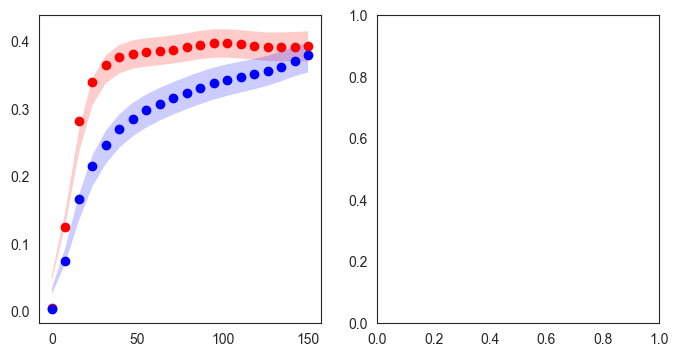

In [31]:

from scipy.ndimage.filters import gaussian_filter1d
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

fig, axs = plt.subplots(1,2,figsize=(8,4))

fig.patch.set_alpha(0)

RSNR_masked=RSNR[RSNAtlas,SurfaceMask[:5000]==1]
yeo7,YeoIndices=np.unique(RSNR_masked,return_inverse=True)


power=2

X=ind_fc_vw_h_l[0,0,:]

smoothing=0.9
mu=ind_fc_vw_ev_l[:,tempData1==2,:].mean(axis=0).mean(axis=0)

sigma = ind_fc_vw_ev_l[:,tempData1==2,:].std(axis=0).mean(axis=0)*1.96/np.power(51,0.5)


mu_s = gaussian_filter1d(mu, sigma=smoothing)
sigma_s = gaussian_filter1d(sigma, sigma=smoothing)

axs[0].fill_between(X, mu_s-sigma_s, mu_s+sigma_s, facecolor='red',
                edgecolor='none', alpha=0.2)
axs[0].plot(X, mu, 'o',color='red')

mu=ind_fc_vw_ev_l[:,tempData1==1,:].mean(axis=0).mean(axis=0)

sigma = ind_fc_vw_ev_l[:,tempData1==1,:].std(axis=0).mean(axis=0)*1.96/np.power(51,0.5)


mu_s = gaussian_filter1d(mu, sigma=smoothing)
sigma_s = gaussian_filter1d(sigma, sigma=smoothing)

axs[0].fill_between(X, mu_s-sigma_s, mu_s+sigma_s, facecolor='blue',
                edgecolor='none', alpha=0.2)
axs[0].plot(X, mu, 'o',color='blue')



plt.savefig('./imagesAvG/ClusterTemp.png',dpi=300) 



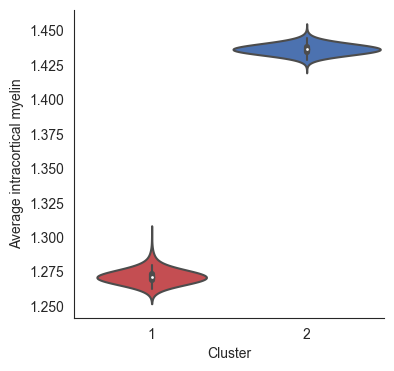

In [33]:
AllMye=np.loadtxt('AllMyelin10k.txt').T
AllMyeLeft=AllMye[:5000,:]
#print(AllMyeLeft.shape)
AllMyeReduced=AllMyeLeft[SurfaceMask[:5000]==1,:]
RSNL=RSN[:,:5000]
RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7,YeoIndices=np.unique(RSNL_masked,return_inverse=True)
AllMyeReducedNoWall=AllMyeReduced[YeoIndices>0,:]

fig = plt.figure(figsize=(4,4))

sns.set_style("white")

#my_pal={[1,0,0],"b"}
my_pal={'r',"b"}
data=np.vstack((np.mean(AllMyeReducedNoWall[fl_l==2],axis=0), np.mean(AllMyeReducedNoWall[fl_l==1],axis=0))).T

ax = sns.violinplot(data=data,palette=my_pal,inner="box",orient='v',saturation=1,bw=1,cut=2,width=0.95)
ax.set_xticklabels(['1','2'])
ax.set(xlabel='Cluster', ylabel='Average intracortical myelin')
sns.despine(offset=0, trim=False);

fig.savefig('./imagesAvG/MyelinByCluster.png')


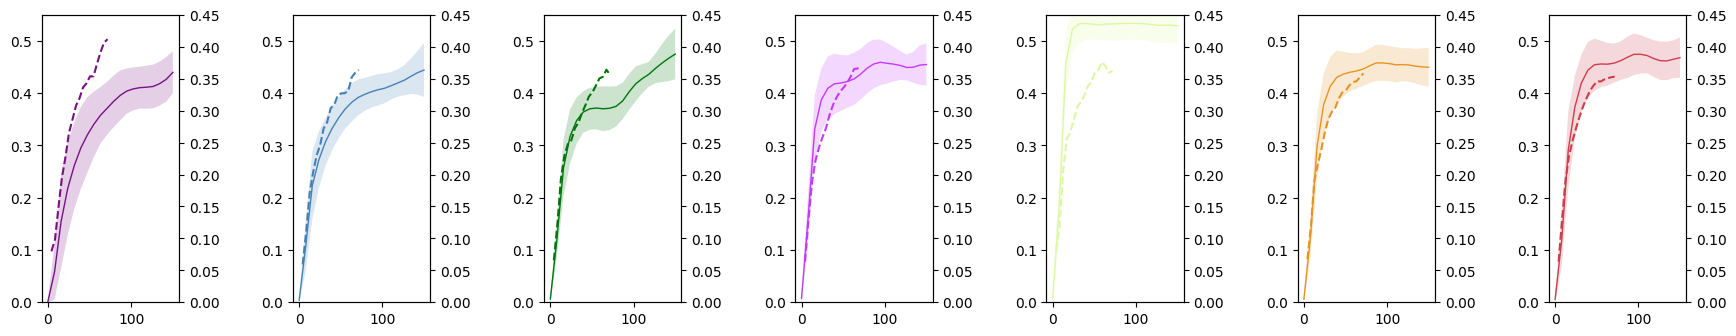

In [34]:
%matplotlib inline
import glob
import h5py
import numpy as np
#from brainspace.gradient import GradientMaps
#from brainspace.gradient import alignment
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import helpers
import scipy.io
import seaborn as sns; sns.set_theme(color_codes=True)

num_bins=20


f = scipy.io.loadmat('./data_PRIME/geo_distance/Schaefer400_L.mat')

GeoDistL=f['geoParcel_L']

f = scipy.io.loadmat('./data_PRIME/geo_distance/Schaefer400_R.mat')

GeoDistR=f['geoParcel_R']

f=scipy.io.loadmat('./data_PRIME/site-newcastle/FC_GroupAvg_Schaefer400.mat')
#f=scipy.io.loadmat('/Users/robleech/Desktop/data_PRIME/site-oxford/FC_GroupAvg_Schaefer400.mat')
#f=scipy.io.loadmat('/Users/robleech/Desktop/data_PRIME/site-ucdavis/FC_GroupAvg_Schaefer400.mat')


FC=f['FC']


FC_left=FC[np.ix_(np.arange(200),np.arange(200))]


FC_right=FC[np.ix_(np.arange(200)+200,np.arange(200)+200)] #check
h_l,ev_l=helpers.emp_variogram_conn(FC_left,GeoDistL,num_bins,[0,80])
h_r,ev_r=helpers.emp_variogram_conn(FC_right,GeoDistR,num_bins,[0,80])

hVw_l,evVw_l=helpers.emp_variogram_vwise_conn(FC_left,GeoDistL,num_bins,[0,80]) #vary last number for maximum range 
hVw_r,evVw_r=helpers.emp_variogram_vwise_conn(FC_right,GeoDistR,num_bins,[0,80]) #vary last number for maximum range 




Schaeffer400LUT=np.loadtxt('Schaeffer400Colors.txt')
Schaeffer400Labels=np.loadtxt('Schaeffer400Yeo7Labels.txt',dtype=str)

indexes = np.unique(Schaeffer400Labels, return_index=True)[1]
[Schaeffer400Labels[index] for index in sorted(indexes)]


indexes = np.unique(Schaeffer400Labels, return_index=True)[1]
Yeo7_Monkey_ev_l=np.zeros([indexes.shape[0],num_bins])
Yeo7_Monkey_h_l=np.zeros([indexes.shape[0],num_bins])
Yeo7_Monkey_ev_r=np.zeros([indexes.shape[0],num_bins])
Yeo7_Monkey_h_r=np.zeros([indexes.shape[0],num_bins])

for i,index in enumerate(sorted(indexes)):
    Yeo7_Monkey_ev_l[i,:]=evVw_l[Schaeffer400Labels[:200]==Schaeffer400Labels[index],:].mean(axis=0)
    Yeo7_Monkey_h_l[i,:]=hVw_l[Schaeffer400Labels[:200]==Schaeffer400Labels[index],:].mean(axis=0)
    Yeo7_Monkey_ev_r[i,:]=evVw_r[Schaeffer400Labels[200:]==Schaeffer400Labels[index],:].mean(axis=0)
    Yeo7_Monkey_h_r[i,:]=hVw_r[Schaeffer400Labels[200:]==Schaeffer400Labels[index],:].mean(axis=0)

    



from matplotlib import colors
hVw_l,evVw_l=helpers.emp_variogram_vwise_conn(FC_l,dist_file_masked,num_bins,[0,150]) #vary last number for maximum range 
hVw_r,evVw_r=helpers.emp_variogram_vwise_conn(FC_r,dist_file_masked_r,num_bins,[0,150]) #vary last number for maximum range 

indexes = np.unique(Schaeffer400Labels, return_index=True)[1]
LUT=[Schaeffer400LUT[index] for index in sorted(indexes)]

NumNetworks=7


plt.style.use('default')
fig = plt.figure(figsize=(9*2,4))
fig.patch.set_alpha(0)
count=0
for i in range(NumNetworks):
    ax = fig.add_subplot(1,NumNetworks, count+1)
    rgbtohex=colors.to_hex(LUT[i])
    plt.plot(Yeo7_Monkey_h_l[i,1:18],Yeo7_Monkey_ev_l[i,1:18],c=rgbtohex,linestyle='dashed')
    ax.set_ylim(bottom=0, top=0.55)
    count=count+1
    
YeoNames=['NONE',
'7Networks_3',
'7Networks_6',
'7Networks_7',
'7Networks_1',
'7Networks_5',
'7Networks_2',
'7Networks_4'];

 

side='left'
RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNL=RSN[:,:5000]


RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7=np.unique(RSNL_masked)
vw_yeo=np.zeros([len(yeo7),num_bins])
vw_yeo_sd=np.zeros([len(yeo7),num_bins])
for i,YeoID in enumerate(yeo7):
    vw_yeo[i,:]=evVw_l[RSNL_masked==YeoID].mean(axis=0)
    vw_yeo_sd[i,:]=evVw_l[RSNL_masked==YeoID].std(axis=0)
    


YeoColors=np.loadtxt('Yeo2011_7Networks_ColorLUT.txt','str')


count=0
axs = fig.get_axes()
for i in range(7):
    for j in range(8):
        if YeoColors[i+1][1]==YeoNames[j]:
            x=hVw_l[0,:]
            y=vw_yeo[j,:]
            y_sd=vw_yeo_sd[j,:]
            temp_col=np.asarray([YeoColors[i+1][2],YeoColors[i+1][3],YeoColors[i+1][4]], dtype=int)
            axs[count].grid(False)
            rgbtohex=colors.to_hex(temp_col/255)
            ax2 = axs[count].twinx() 
            ax2.fill_between(x, y-y_sd, y+y_sd, facecolor=rgbtohex,edgecolor='none', alpha=0.2)
            ax2.plot(x, y, color=rgbtohex, lw=1)
            ax2.grid(False)
            
            ax2.set_ylim(bottom=0, top=0.45)


            count=count+1


fig.tight_layout(pad=3.0)


plt.savefig('./imagesAvG/VWByYeoMonkeyHumanLeft.png')


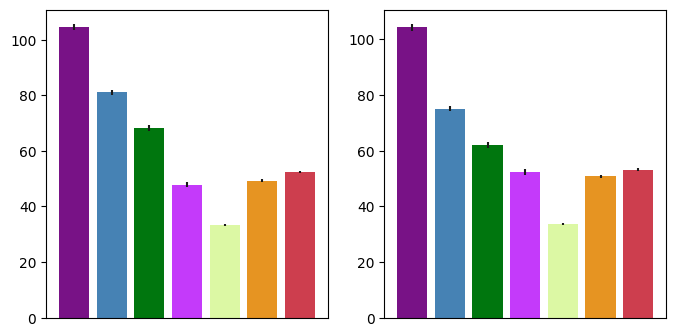

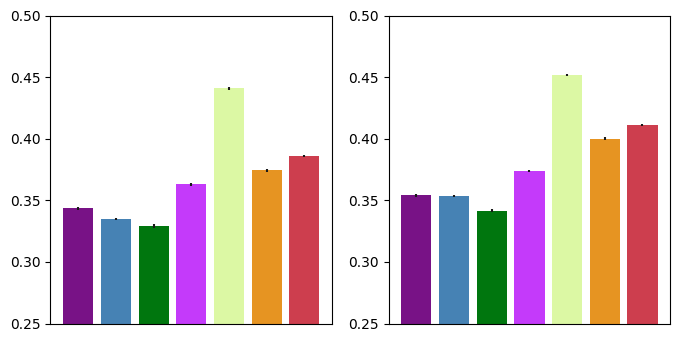

In [48]:

from matplotlib import colors


YeoNames=['NONE',
'7Networks_3',
'7Networks_6',
'7Networks_7',
'7Networks_1',
'7Networks_5',
'7Networks_2',
'7Networks_4'];

 

side='left'
RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNL=RSN[:,:5000]


RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7=np.unique(RSNL_masked)
vw_yeo_Range=np.zeros([len(yeo7)])
vw_yeo_Range_sd=np.zeros([len(yeo7)])
for i,YeoID in enumerate(yeo7):
    vw_yeo_Range[i]=ModelCof_evVw_l[RSNL_masked==YeoID,1,0].mean()
    vw_yeo_Range_sd[i]=ModelCof_evVw_l[RSNL_masked==YeoID,1,0].std()/np.power(np.sum(RSNL_masked==YeoID),0.5)
    


YeoColors=np.loadtxt('Yeo2011_7Networks_ColorLUT.txt','str')

fig = plt.figure(figsize=(8,4))
fig.patch.set_alpha(0)
count=0

ax = fig.add_subplot(1,2, 1)
for i in range(7):
    for j in range(8):
        if YeoColors[i+1][1]==YeoNames[j]:
            #x=hVw_l[0,:]
            #print(vw_yeo_Range[j])
            temp_col=np.asarray([YeoColors[i+1][2],YeoColors[i+1][3],YeoColors[i+1][4]], dtype=int)
            rgbtohex=colors.to_hex(temp_col/255)
            
            ax.bar(count,vw_yeo_Range[j],yerr=vw_yeo_Range_sd[j],color=rgbtohex)
            count=count+1

ax.set_xticklabels([])
ax.set_xticks([]) 
ax = fig.add_subplot(1,2, 2)


RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNR=RSN[:,5000:]
RSNR_masked=RSNR[RSNAtlas,SurfaceMask[5000:]==1]
yeo7=np.unique(RSNR_masked)
vw_yeo_Range=np.zeros([len(yeo7)])
vw_yeo_Range_sd=np.zeros([len(yeo7)])

for i,YeoID in enumerate(yeo7):
    vw_yeo_Range[i]=ModelCof_evVw_r[RSNR_masked==YeoID,1,0].mean()
    vw_yeo_Range_sd[i]=ModelCof_evVw_r[RSNR_masked==YeoID,1,0].std()/np.power(np.sum(RSNR_masked==YeoID),0.5)
    



for i in range(7):
    for j in range(8):
        if YeoColors[i+1][1]==YeoNames[j]:
            #x=hVw_l[0,:]
            #print(vw_yeo_Range[j])
            temp_col=np.asarray([YeoColors[i+1][2],YeoColors[i+1][3],YeoColors[i+1][4]], dtype=int)
            rgbtohex=colors.to_hex(temp_col/255)
            
            ax.bar(count,vw_yeo_Range[j],yerr=vw_yeo_Range_sd[j],color=rgbtohex)
            count=count+1
            
ax.set_xticklabels([])
ax.set_xticks([])
  
plt.savefig('./imagesAvG/VWRangeByYeo.png')



side='left'
RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNL=RSN[:,:5000]


RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7=np.unique(RSNL_masked)
vw_yeo_Range=np.zeros([len(yeo7)])
vw_yeo_Range_sd=np.zeros([len(yeo7)])
for i,YeoID in enumerate(yeo7):
    vw_yeo_Range[i]=ModelCof_evVw_l[RSNL_masked==YeoID,1,1].mean()
    vw_yeo_Range_sd[i]=ModelCof_evVw_l[RSNL_masked==YeoID,1,1].std()/np.power(np.sum(RSNL_masked==YeoID),0.5)
    


YeoColors=np.loadtxt('Yeo2011_7Networks_ColorLUT.txt','str')

fig = plt.figure(figsize=(8,4))
fig.patch.set_alpha(0)
count=0

ax = fig.add_subplot(1,2, 1)
for i in range(7):
    for j in range(8):
        if YeoColors[i+1][1]==YeoNames[j]:
            #x=hVw_l[0,:]
            #print(vw_yeo_Range[j])
            temp_col=np.asarray([YeoColors[i+1][2],YeoColors[i+1][3],YeoColors[i+1][4]], dtype=int)
            rgbtohex=colors.to_hex(temp_col/255)
            
            ax.bar(count,vw_yeo_Range[j],yerr=vw_yeo_Range_sd[j],color=rgbtohex)
            count=count+1

ax.set_xticklabels([])
ax.set_xticks([]) 
ax.set_ylim(0.25,0.5)
ax = fig.add_subplot(1,2, 2)


RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNR=RSN[:,5000:]
RSNR_masked=RSNR[RSNAtlas,SurfaceMask[5000:]==1]
yeo7=np.unique(RSNR_masked)
vw_yeo_Range=np.zeros([len(yeo7)])
vw_yeo_Range_sd=np.zeros([len(yeo7)])

for i,YeoID in enumerate(yeo7):
    vw_yeo_Range[i]=ModelCof_evVw_r[RSNR_masked==YeoID,1,1].mean()
    vw_yeo_Range_sd[i]=ModelCof_evVw_r[RSNR_masked==YeoID,1,1].std()/np.power(np.sum(RSNR_masked==YeoID),0.5)
    



for i in range(7):
    for j in range(8):
        if YeoColors[i+1][1]==YeoNames[j]:
            #x=hVw_l[0,:]
            #print(vw_yeo_Range[j])
            temp_col=np.asarray([YeoColors[i+1][2],YeoColors[i+1][3],YeoColors[i+1][4]], dtype=int)
            rgbtohex=colors.to_hex(temp_col/255)
            
            ax.bar(count,vw_yeo_Range[j],yerr=vw_yeo_Range_sd[j],color=rgbtohex)
            count=count+1
            
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_ylim(0.25,0.5)
  
plt.savefig('./imagesAvG/VVSillByYeo.png')




(51, 2, 2)


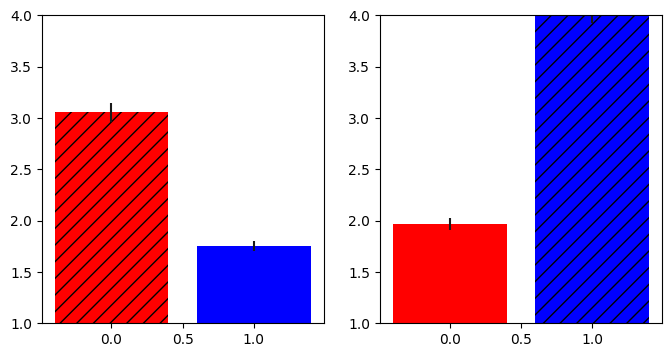

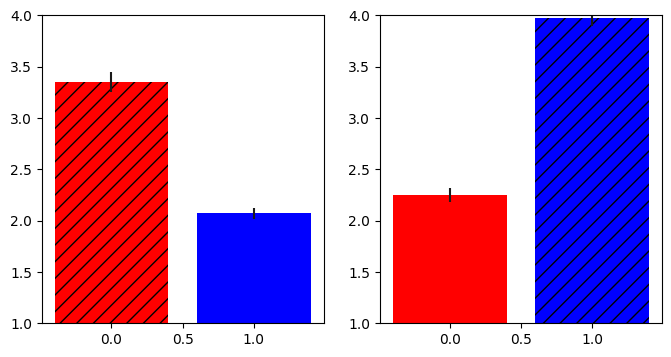

In [22]:

yeo7,YeoIndices=np.unique(RSNL_masked,return_inverse=True)
vw_clust_ind1=np.zeros([ind_fc_vw_ev_l.shape[0],2,ind_fc_vw_ev_l.shape[2]])
vw_clust_ind2=np.zeros([ind_fc2_vw_ev_l.shape[0],2,ind_fc2_vw_ev_l.shape[2]])
for i in range(51):
    vw_clust_ind1[i,0,:]=ind_fc_vw_ev_l[i,YeoIndices>0,:][np.where(fl_l==1)].mean(axis=0)
    vw_clust_ind2[i,0,:]=ind_fc2_vw_ev_l[i,YeoIndices>0,:][np.where(fl_l==1)].mean(axis=0)
    vw_clust_ind1[i,1,:]=ind_fc_vw_ev_l[i,YeoIndices>0,:][np.where(fl_l==2)].mean(axis=0)
    vw_clust_ind2[i,1,:]=ind_fc2_vw_ev_l[i,YeoIndices>0,:][np.where(fl_l==2)].mean(axis=0)

    
Clust_cross_sample_corrs=np.zeros([vw_yeo_ind1.shape[0],2,2])
for i in range(vw_clust_ind1.shape[0]):
    for j in range(vw_clust_ind1.shape[1]):
        for k in range(vw_clust_ind2.shape[1]):
             
            Clust_cross_sample_corrs[i,j,k]=np.arctanh(np.corrcoef(vw_clust_ind1[i,j,:],vw_clust_ind2[i,k,:])[0][1])

print(Clust_cross_sample_corrs.shape)
mean_clust=Clust_cross_sample_corrs.mean(axis=0)
std_clust=Clust_cross_sample_corrs.std(axis=0)

fig = plt.figure(figsize=(8,4))

for i in range(2):
    ax = fig.add_subplot(1,2, i+1)
    plt.bar(np.arange(2),mean_clust[i,:],bottom=0,yerr=std_clust[i,:]/np.power(51,0.5),color=['red','blue'])

    if i ==0:
        plt.bar(i,mean_clust[i,0],bottom=0,hatch="//",color='red')
    else:
        plt.bar(i,mean_clust[i,1],bottom=0,hatch="//",color='blue')

    plt.ylim(1,4)

fig.savefig('./imagesAvG/CrossScanSimilarityVariogeramsByClust_l.png')





yeo7,YeoIndices=np.unique(RSNR_masked,return_inverse=True)
vw_clust_ind1=np.zeros([ind_fc_vw_ev_r.shape[0],2,ind_fc_vw_ev_r.shape[2]])
vw_clust_ind2=np.zeros([ind_fc2_vw_ev_r.shape[0],2,ind_fc2_vw_ev_r.shape[2]])
for i in range(51):
    vw_clust_ind1[i,0,:]=ind_fc_vw_ev_r[i,YeoIndices>0,:][np.where(fl_l==1)].mean(axis=0)
    vw_clust_ind2[i,0,:]=ind_fc2_vw_ev_r[i,YeoIndices>0,:][np.where(fl_l==1)].mean(axis=0)
    vw_clust_ind1[i,1,:]=ind_fc_vw_ev_r[i,YeoIndices>0,:][np.where(fl_l==2)].mean(axis=0)
    vw_clust_ind2[i,1,:]=ind_fc2_vw_ev_r[i,YeoIndices>0,:][np.where(fl_l==2)].mean(axis=0)

    
Clust_cross_sample_corrs=np.zeros([vw_yeo_ind1.shape[0],2,2])
for i in range(vw_clust_ind1.shape[0]):
    for j in range(vw_clust_ind1.shape[1]):
        for k in range(vw_clust_ind2.shape[1]):
    
            Clust_cross_sample_corrs[i,j,k]=np.arctanh(np.corrcoef(vw_clust_ind1[i,j,:],vw_clust_ind2[i,k,:])[0][1])

mean_clust=Clust_cross_sample_corrs.mean(axis=0)
std_clust=Clust_cross_sample_corrs.std(axis=0)
fig = plt.figure(figsize=(8,4))

for i in range(2):
    ax = fig.add_subplot(1,2, i+1)
    plt.bar(np.arange(2),mean_clust[i,:],bottom=0,yerr=std_clust[i,:]/np.power(51,0.5),color=['red','blue'])
    #plt.bar(i,mean_clust[i,:],bottom=0,edgecolor=[0,0,0,1],hatch="//")
    if i ==0:
        plt.bar(i,mean_clust[i,0],bottom=0,hatch="//",color='red')
    else:
        plt.bar(i,mean_clust[i,1],bottom=0,hatch="//",color='blue')
    #plt.ylim(1,4)
    plt.ylim(1,4)
    #plt.ylim(0.8,1.2)
fig.savefig('./imagesAvG/CrossScanSimilarityVariogeramsByClust_r.png')

#plt.bar(x=np.arange(2),height=mean_clust[0][:],yerr=std_clust[0][:])




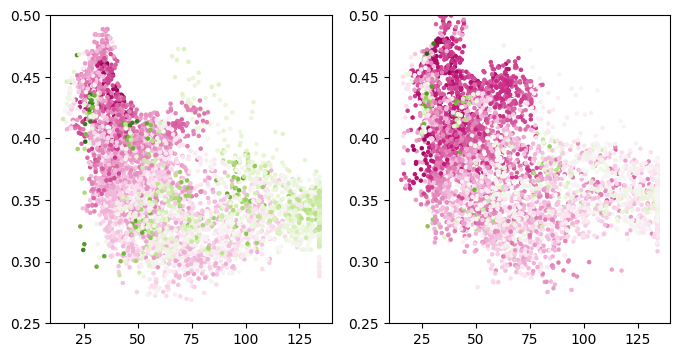

In [14]:

# plt.savefig('/Users/robleech/Dropbox/BrainSmash/imagesAvG/RangeSill_Gradient_3.png')

import matplotlib 
matplotlib.rc_file_defaults()


Myelin=np.loadtxt('Myelin10k.txt')
tempData=Myelin[:5000]
MyelinReduced=tempData[SurfaceMask[:5000]==1]

cmap='PiYG'
fig, axs = plt.subplots(1,2,figsize=(8,4))
fig.patch.set_alpha(0)
axs[0].scatter(ModelCof_evVw_l[:,1,0],ModelCof_evVw_l[:,1,1],c=MyelinReduced,cmap=cmap,s=5)
axs[0].grid(False)
axs[0].set_ylim(bottom=0.25, top=0.5)
#axs[0].spines['top'].set_visible(False)
#axs[0].spines['right'].set_visible(False)

tempData=Myelin[5000:]
MyelinReduced=tempData[SurfaceMask[5000:]==1]
fig.patch.set_alpha(0)
im=axs[1].scatter(ModelCof_evVw_r[:,1,0],ModelCof_evVw_r[:,1,1],c=MyelinReduced,cmap=cmap,s=5)
axs[1].grid(False)
axs[1].set_ylim(bottom=0.25, top=0.5)
#axs[1].spines['top'].set_visible(False)
#axs[1].spines['right'].set_visible(False)
plt.savefig('./imagesAvG/MyelinRangeSill.png')



In [15]:
#avG=np.loadtxt('G3_Average10k.txt').T[:5000,:]
#avGReduced=avG[SurfaceMask[:5000]==1,0]
#ax = fig.add_subplot()

#ax = fig.add_subplot(projection='3d')

#ax.scatter(pca_evVw[:,0], pca_evVw[:,1], pca_evVw[:,2],c=RSNL_masked)
YeoNames=['NONE',
'7Networks_3',
'7Networks_6',
'7Networks_7',
'7Networks_1',
'7Networks_5',
'7Networks_2',
'7Networks_4'];
 


side='left'
RSNAtlas=0
RSN=np.loadtxt('RSN10k.txt')
SurfaceMask=np.loadtxt('surfBilateralMask.txt')
RSNL=RSN[:,:5000]


RSNL_masked=RSNL[RSNAtlas,SurfaceMask[:5000]==1]
yeo7=np.unique(RSNL_masked)
vw_yeo_ind1=np.zeros([numFiles,len(yeo7),num_bins])
vw_yeo_ind2=np.zeros([numFiles,len(yeo7),num_bins])
#ind_vw_yeo_sd=np.zeros([len(yeo7),num_bins])
for i in range(numFiles):
    for j,YeoID in enumerate(yeo7):
        vw_yeo_ind1[i,j,:]=ind_fc_vw_ev_l[i,RSNL_masked==YeoID,:].mean(axis=0)
        vw_yeo_ind2[i,j,:]=ind_fc2_vw_ev_l[i,RSNL_masked==YeoID,:].mean(axis=0)
    #vw_yeo_sd_ind[j,i,:]=evVw_l[RSNL_masked==YeoID].std(axis=0)
    

    #vw_yeo_sd_ind[j,i,:]=evVw_l[RSNL_masked==YeoID].std(axis=0)
    
    
RSNR=RSN[:,5000:]


RSNR_masked=RSNL[RSNAtlas,SurfaceMask[5000:]==1]
yeo7=np.unique(RSNR_masked)
vw_yeo_ind1_r=np.zeros([numFiles,len(yeo7),num_bins])
vw_yeo_ind2_r=np.zeros([numFiles,len(yeo7),num_bins])
#ind_vw_yeo_sd=np.zeros([len(yeo7),num_bins])
for i in range(numFiles):
    for j,YeoID in enumerate(yeo7):
        vw_yeo_ind1_r[i,j,:]=ind_fc_vw_ev_r[i,RSNR_masked==YeoID,:].mean(axis=0)
        vw_yeo_ind2_r[i,j,:]=ind_fc2_vw_ev_r[i,RSNR_masked==YeoID,:].mean(axis=0)
    #vw_yeo_sd_ind[j,i,:]=evVw_l[RSNL_masked==YeoID].std(axis=0)
    


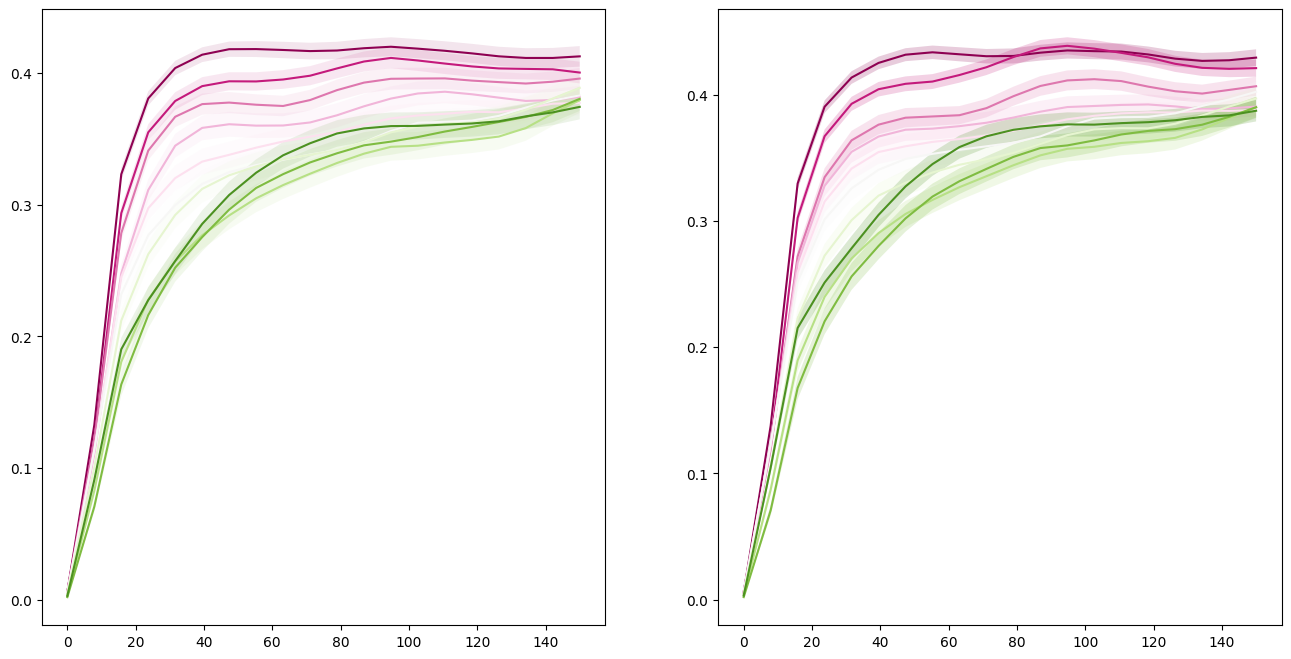

In [16]:

Myelin=np.loadtxt('Myelin10k.txt')


tempData=Myelin[:5000]
MyelinReduced=tempData[SurfaceMask[:5000]==1]

percent_width=10
fig=plt.figure(figsize=(8*2,8))
ax = fig.add_subplot(1,2, 1)
fig.patch.set_alpha(0)
count=0
ind_ev_meanByMyelin=np.zeros([51,10,20])
for i in range(0, 100, percent_width):
    
    for j in range(51):
        lowP=np.percentile(MyelinReduced, i)
        highP=np.percentile(MyelinReduced, i+percent_width)
        ind_ev_meanByMyelin[j,count,:]=ind_fc_vw_ev_l[j,np.where((MyelinReduced > lowP) & (MyelinReduced <= highP)),:].mean(axis=1)[0]
        
    tempAv=ind_ev_meanByMyelin[:,count,:].mean(axis=0).T
    tempStd=ind_ev_meanByMyelin[:,count,:].std(axis=0).T/np.sqrt(51)

    color=i/100
    cmap = matplotlib.cm.get_cmap('PiYG')
    rgba = cmap(color)
    ax.plot(ind_fc_vw_h_l[0,0,:],tempAv,label=[str(i)],c=rgba)

    ax.fill_between(ind_fc_vw_h_l[0,0,:], tempAv-tempStd, tempAv+tempStd,facecolor=rgba,edgecolor='none', alpha=0.1)
    count=count+1
    


tempData=Myelin[5000:]
MyelinReduced=tempData[SurfaceMask[5000:]==1]

percent_width=10

ax = fig.add_subplot(1,2, 2)

count=0
ind_ev_meanByMyelin=np.zeros([51,10,20])
for i in range(0, 100, percent_width):
    
    for j in range(51):
        lowP=np.percentile(MyelinReduced, i)
        highP=np.percentile(MyelinReduced, i+percent_width)

        ind_ev_meanByMyelin[j,count,:]=ind_fc_vw_ev_r[j,np.where((MyelinReduced > lowP) & (MyelinReduced <= highP)),:].mean(axis=1)[0]
        
    tempAv=ind_ev_meanByMyelin[:,count,:].mean(axis=0)
    tempStd=ind_ev_meanByMyelin[:,count,:].std(axis=0)/np.sqrt(51)
    color=i/100
    cmap = matplotlib.cm.get_cmap('PiYG')
    rgba = cmap(color)


    ax.plot(ind_fc_vw_h_r[0,0,:],tempAv,label=[str(i)],c=rgba)

    ax.fill_between(ind_fc_vw_h_r[0,0,:], tempAv-tempStd, tempAv+tempStd,facecolor=rgba,edgecolor='none', alpha=0.2)
    count=count+1
        
    
    
    
#plt.legend()
fig.savefig('./imagesAvG/VW_Vg_ByMyelinDeciles.png',transparent=True)



In [21]:
import matplotlib 
from adjustText import adjust_text
matplotlib.rc_file_defaults()

Tasks=np.loadtxt('TopicAll50.txt')

SurfaceMask=np.loadtxt('surfBilateralMask.txt')

Topics50TNames=np.loadtxt('TermMaps/TopicOrder.txt',delimiter=',',dtype='str')



SurfaceMask=np.loadtxt('surfBilateralMask.txt')


Topics50TNames=np.loadtxt('TermMaps/TopicOrder.txt',delimiter=',',dtype='str')


taskIndices=[6,7,8,9,10,12,17,18,20,23,25,26,30,31,34,35,36,38,39,41,46,47,48,49]

TopicNamesSimplified=['cognitive','inhibition','motor','numerical','action','conflict','spatial','emotion','empathy','decision','pain','memory','language','semantic','face','imagery','visual','eye movement','motion','attention','auditory','reward','social','working memory']
TasksL=Tasks[taskIndices,:5000]
TasksR=Tasks[taskIndices,5000:]

TasksL_masked=TasksL[:,SurfaceMask[:5000]==1]
TasksR_masked=TasksL[:,SurfaceMask[5000:]==1]


ModelAvByTask=np.zeros([24,2])
ModelAvByTaskR=np.zeros([24,2])


for i in range(24):
    ModelAvByTask[i,0]=ModelCof_evVw_l[np.abs(TasksL_masked[i,:])>10,1,0].mean()
    ModelAvByTask[i,1]=ModelCof_evVw_l[np.abs(TasksL_masked[i,:])>10,1,1].mean()

    ModelAvByTaskR[i,0]=ModelCof_evVw_r[np.abs(TasksR_masked[i,:])>10,1,0].mean()
    ModelAvByTaskR[i,1]=ModelCof_evVw_r[np.abs(TasksR_masked[i,:])>10,1,1].mean()




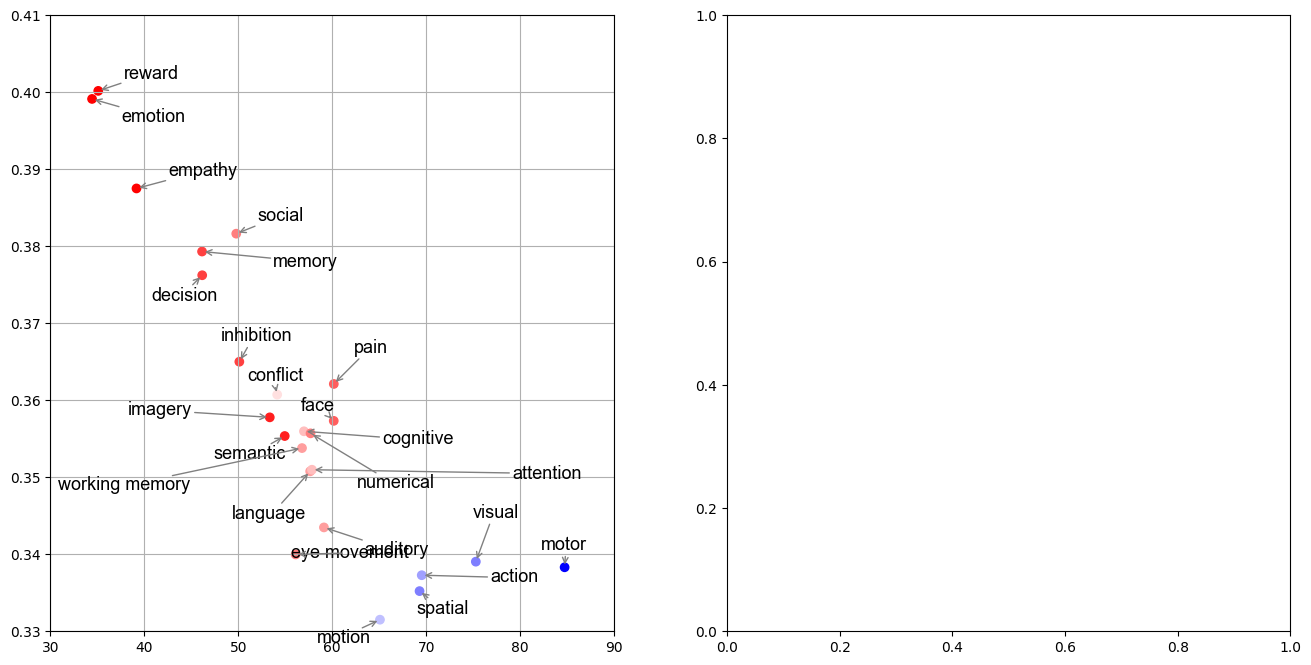

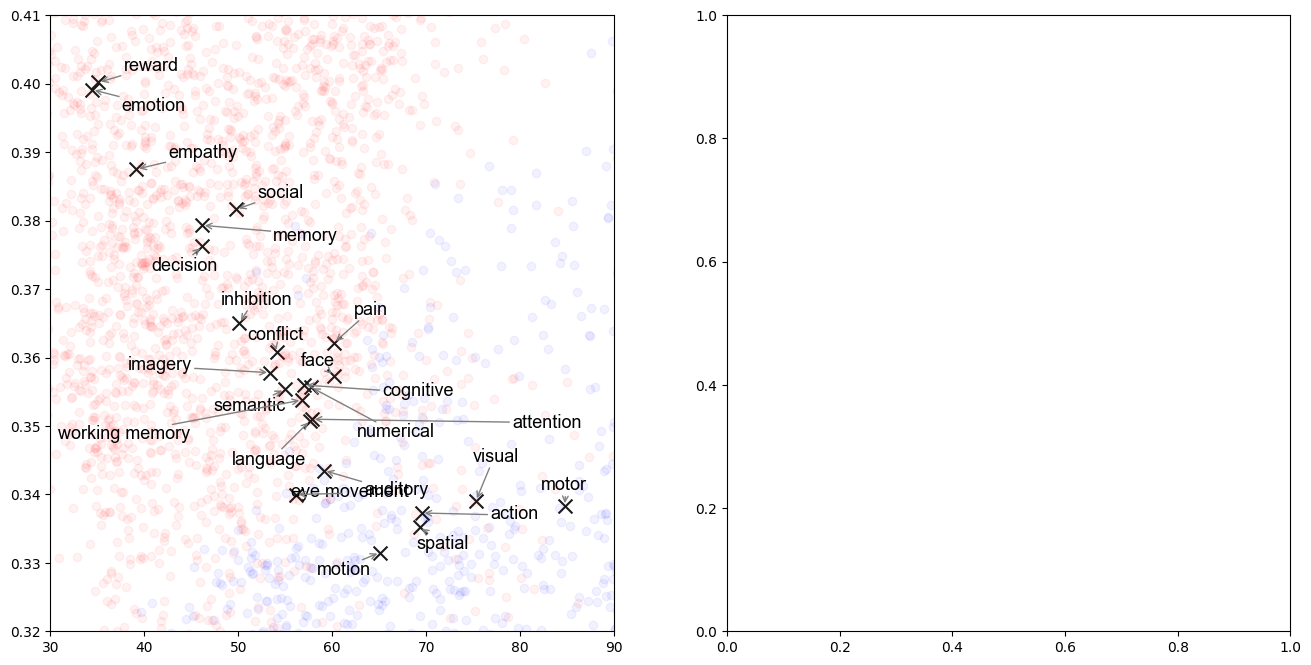

In [20]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=5)
knn.fit(ModelCof_evVw_l[YeoIndices>0,1,0:2])
#NearestNeighbors(algorithm='auto', n_neighbors=1)
#nn_fl_l=fl_l[knn.kneighbors(ModelAvByTask, return_distance=False,n_neighbors=1)].ravel()
nn_fl_l=fl_l[knn.kneighbors(ModelAvByTask, return_distance=False,n_neighbors=20)]
nn_fl_lAv=np.mean(nn_fl_l,axis=1)



X=ModelAvByTask[:,0]
Y=ModelAvByTask[:,1]
fig, axs = plt.subplots(1,2,figsize=(16,8))
fig.patch.set_alpha(0)
axs[0].scatter(X,Y,c=nn_fl_lAv,marker = 'o',cmap='bwr')
#axs[0].scatter(X[nn_fl_lAv==1],Y[nn_fl_lAv==1],c='blue',marker = 'o')
texts = [axs[0].text(X[i], Y[i], TopicNamesSimplified[i],fontname="Arial",fontsize=13) for i in range(len(X))]
#adjust_text(texts,arrowprops=dict(arrowstyle='->', color='red'))
adjust_text(texts,ax=axs[0],arrowprops=dict(arrowstyle='->', color='grey'),expand_text=(2, 2), expand_points=(2, 2))
axs[0].set_ylim(bottom=0.33, top=0.41)
axs[0].set_xlim(left=30, right=90)
#axs[0].set_clim(vmin=1, vmax=2)
axs[0].grid(True)
for im in plt.gca().get_images():
    im.set_clim(1, 2)

plt.savefig('./imagesAvG/TaskRangeSillAltCluster.png',dpi=300) 


fig, axs = plt.subplots(1,2,figsize=(16,8))
fig.patch.set_alpha(0)
axs[0].scatter(X,Y,c='k',marker = 'x',s=100)

texts = [axs[0].text(X[i], Y[i], TopicNamesSimplified[i],fontname="Arial",fontsize=13) for i in range(len(X))]

adjust_text(texts,ax=axs[0],arrowprops=dict(arrowstyle='->', color='grey'),expand_text=(2, 2), expand_points=(2, 2))
X=ModelCof_evVw_l[YeoIndices>0,1,0]
Y=ModelCof_evVw_l[YeoIndices>0,1,1]

axs[0].scatter(X[fl_l==2],Y[fl_l==2],c='red',marker = 'o',alpha=0.05)
axs[0].scatter(X[fl_l==1],Y[fl_l==1],c='blue',marker = 'o',alpha=0.05)

axs[0].set_ylim(bottom=0.32, top=0.41)
axs[0].set_xlim(left=30, right=90)

plt.savefig('./imagesAvG/TaskRangeSillOverlayCluster.png',dpi=300) 